## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test2
import friedman3Dataset
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean 
import catboost as ctb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np

## Parameters 

In [3]:
variance = 1

## Dataset - California Dataset


In [4]:
#Parameters 
n_features = 4
n_samples= 100
n_target = 1 

In [5]:
X,Y = friedman3Dataset.friedman3_data(n_samples)

         X0        X1        X2        X3        X4         Y
0  0.579153  0.227116 -1.041126 -0.551112  0.585615  0.720928
1  0.524280 -1.340465 -1.722464  1.135564  0.910464  1.025038
2 -1.579545 -0.733344 -0.448438 -1.527568  1.374978 -1.728393
3 -0.593539 -0.110458  0.272133  0.859172 -1.164705 -0.341070
4 -1.342454  0.374868  1.212883 -0.970296  0.549107 -0.808902


In [6]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)


## Training Parameters 

In [7]:
batch_size = 32
n_epochs = 1000
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ABC Pre-generator Model 

1. The catboost model is used as a pre-generator model for the ABC-GAN. 
2. The model is first trained on the entire dataset 
3. It generats X,Y pairs and we add some Gaussian noise with mean 0 and variance 1 to it which is then feed as input to the generator.


In [8]:
#Train the Model 
prior_model = ctb.CatBoostRegressor()
prior_model.fit(X_train,Y_train)

Learning rate set to 0.024897
0:	learn: 0.9683296	total: 57.6ms	remaining: 57.5s
1:	learn: 0.9594475	total: 58.4ms	remaining: 29.1s
2:	learn: 0.9501438	total: 59ms	remaining: 19.6s
3:	learn: 0.9411313	total: 59.5ms	remaining: 14.8s
4:	learn: 0.9342733	total: 60.1ms	remaining: 12s
5:	learn: 0.9257594	total: 60.6ms	remaining: 10s
6:	learn: 0.9164638	total: 61.2ms	remaining: 8.68s
7:	learn: 0.9067743	total: 61.6ms	remaining: 7.64s
8:	learn: 0.8993085	total: 62.2ms	remaining: 6.85s
9:	learn: 0.8920204	total: 62.7ms	remaining: 6.21s
10:	learn: 0.8849787	total: 63.3ms	remaining: 5.69s
11:	learn: 0.8767674	total: 63.8ms	remaining: 5.26s
12:	learn: 0.8691537	total: 64.4ms	remaining: 4.89s
13:	learn: 0.8615268	total: 65.2ms	remaining: 4.59s
14:	learn: 0.8534092	total: 65.7ms	remaining: 4.32s
15:	learn: 0.8464514	total: 66.2ms	remaining: 4.07s
16:	learn: 0.8394908	total: 66.7ms	remaining: 3.86s
17:	learn: 0.8330919	total: 67.2ms	remaining: 3.67s
18:	learn: 0.8264799	total: 67.7ms	remaining: 3.49

In [9]:
y_pred = prior_model.predict(X_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape)
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)

mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mae)

# ABC - GAN Model with skip connection

In [14]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


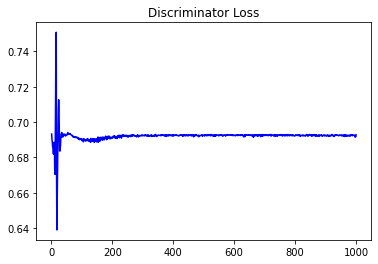

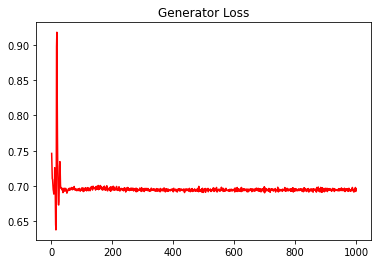

In [15]:
ABC_train_test2.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,prior_model,variance,device)

In [16]:
ABC_GAN3_metrics=ABC_train_test2.test_generator(gen3,test_data,prior_model,variance,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MSE")
print(mean(ABC_GAN3_metrics[0]))

MSE
0.1591131239041244


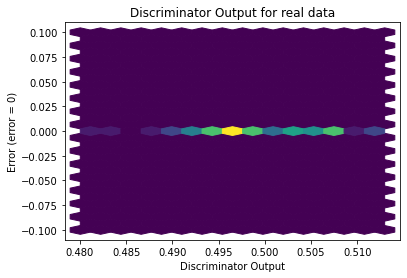

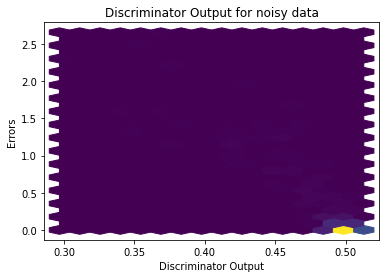

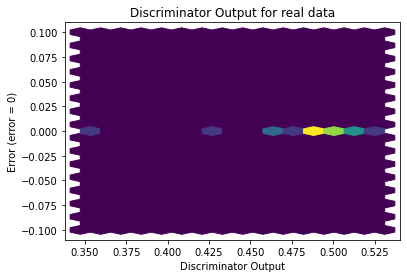

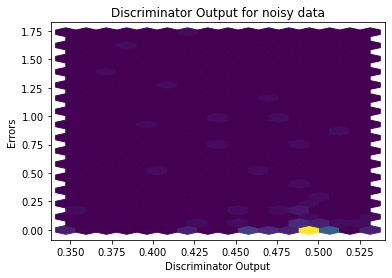

In [17]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [18]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.7997]], requires_grad=True)
